In [3]:
import torch
from torch import optim
from torch import nn

import pandas as pd
import numpy as np

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import PIL
import random
import os
import time

import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval

torch.manual_seed(321)

random.seed(321)

The third and final trial and solving this problem. Here we went back to Siamese Networks again and used the BCELOSS function.

To recap: Siamese Networks work by pass 2 inputs to the same network to be trained side by side and comparing the outputs. Meanwhile, BCELOSS stands for Binary Cross Entropy Loss, which feels appropriate for classifying fake or original images.

The difference between this method and the contrastive loss function is that here we will be calculating the absolute difference between the 2 outputs before they passing the result to the final layer. This way we will have only 1 calculated input, aside from the target, to be passed to the BCELOSS function.

If you did not follow the previous files, here is the problem again:

For this task, we have a set of celebrity images that we want to train a machine learning model on. We want to it to recognize when 2 pictures belong to the same person or not, so that later we can give it any 2 pictures of a random person and it will predict if they do, in fact, belong to the same person or if they are completely different people.

This is how we would normally load in images using pytorch:

Note that we are using pytorch to resize to 255 pixels and center on 224 pixels. This insures all our images are the same size and in sqaure shape.

In [2]:
data_dir = 'facial_recognition_data'

transform = transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform = transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Taking a look at an image:

In [1]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

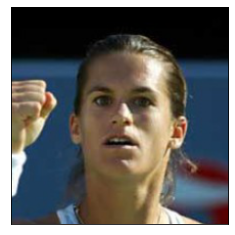

In [4]:
images, labels = next(iter(dataloader))
show_image(images[0])

We will be keeping all the images in one folder and will be doing the preprocessing steps here using the help of pandas.

Now, if we leave things as they are, pytorch will try to classify each celebrity on its own. So, for 1680 celebrities, we would be having an output of 1680 classes. This is not what we want to do. We want our output to be binary in the form of 1 if two incoming pictures belong to the same person or 0 if not.

Therefore, we will need to create a few of our own custom functions. But first, we need to prepare our datasets.

In [5]:
def Noahs_df(imgs):
    '''
    Takes only a pair of images from each folder and returns a dataframe
    
    Args:
        imgs: list of tuples containing paths of images and their folder number
        
    Returns:
        Dataframe containing path and folder columns for each image
    '''
    df_constructor = {'path':[], 'folder':[]}
    for path, folder in imgs:
        if df_constructor['folder'].count(folder) == 2:
            continue
        df_constructor['path'].append(path)
        df_constructor['folder'].append(folder)    

    return pd.DataFrame(df_constructor)

In [6]:
noah = Noahs_df(dataset.imgs)

In [7]:
noah.head()

,path,folder
0,facial_recognition_data\Aaron_Peirsol\Aaron_Pe...,0
1,facial_recognition_data\Aaron_Peirsol\Aaron_Pe...,0
2,facial_recognition_data\Aaron_Sorkin\Aaron_Sor...,1
3,facial_recognition_data\Aaron_Sorkin\Aaron_Sor...,1
4,facial_recognition_data\Abdel_Nasser_Assidi\Ab...,2


Now, we need to create train, validation and test sets. We also need to make sure each one has a length divisible by 8, since later on, we will be using batch size of 8 for machine learning.

In [8]:
testlen =  int(len(noah) * .2)
while (testlen % 8)!=0:
    testlen-=1
testlen

672

In [9]:
vallen = int(((len(noah))-testlen)*.2)
while (vallen % 8)!=0:
    vallen-=1
vallen

536

In [10]:
trainlen = len(noah) - testlen - vallen

In [11]:
while(trainlen %8)!=0:
    trainlen-=1
trainlen

2152

In [12]:
len(noah) - (trainlen+testlen+vallen)

0

Good nothing left over.

In [13]:
train_set = noah.head(trainlen).reset_index(drop=True)
val_set = noah.iloc[trainlen:vallen+trainlen].reset_index(drop=True)
test_set = noah.tail(testlen).reset_index(drop=True)

Checking one last time that all lengths are divisible by 8:

In [174]:
for data in [train_set, test_set, val_set]:
    print(len(data)%8)

0
0
0


In [175]:
class NoahsDataset(Dataset):
    '''
    Prepares data to be given to pytorch's DataLoader. 
    Essentially, a pair of images is returned along with a target label that specifies whether
    the images are the same or not.
    '''
    def __init__(self, image_folder, transform):
        '''
        Creates a dataframe from image_folder tuples and saves the transforms. 
        
        Args:
            image_folder: torchvision.datasets.folder.ImageFolder datatype that
                contains tuples of filepath and folder number.
            transform: image transformation coming from torchvision.transforms.Compose function
        '''
        self.imgs_df = image_folder
        self.imgs1 = self.imgs_df.drop_duplicates(subset='folder', keep='first')
        self.imgs2 = self.imgs_df.drop_duplicates(subset='folder', keep='last')
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs_df)

    def __getitem__(self, index):
        if index < len(self.imgs1):  
            # match the images
            path1 = self.imgs1.iloc[index].path
            path2 = self.imgs2.iloc[index].path
            target = 0
        else:
            # match the self.imgs1 with a random image from self.imgs2
            index -= len(self.imgs1)
            path1 = self.imgs1.iloc[index].path
            path2 = self.imgs2[self.imgs2.index!=index].sample(random_state=index).iloc[0].path
            target = 1

        image1 = Image.open(path1)
        image2 = Image.open(path2)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            
        return image1, image2, torch.tensor(target)


In [390]:
def data_loader(data_folder, transform, batch_size=8, shuffle=True):
    data_set = NoahsDataset(data_folder, transform)
    return DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)

In [391]:
transform = transforms.Compose([transforms.Resize(14*14),
                               transforms.CenterCrop(13*13),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))
                               ])

In [392]:
train_dataloader = data_loader(train_set, transform)

In [393]:
img1, img2, target = next(iter(train_dataloader))

In [394]:
img1.shape

torch.Size([8, 1, 169, 169])

Testing the shapes after each layer:

In [395]:
        conv1 = nn.Conv2d(1, 16, 3, padding=1)
        conv2 = nn.Conv2d(16, 32, 3, padding=1)
        conv3 = nn.Conv2d(32, 64, 3, padding=1)
        pool = nn.MaxPool2d(2)
        fc1 = nn.Linear(64*21*21, 500)
        fc2 = nn.Linear(500, 1)
        dropout = nn.Dropout(0.35)

In [396]:
        x = img1.to('cpu')
        x = pool(F.relu(conv1(x)))
        print('1', x.shape)
        x = pool(F.relu(conv2(x)))
        print('2',x.shape)
        x = pool(F.relu(conv3(x)))
        print('3',x.shape)
        x = x.view(8, -1)        
        print('4',x.shape)
        x = dropout(x)
        x = F.relu(fc1(x))
        print('5',x.shape)
        x = fc2(x)
        print('6',x.shape)

1 torch.Size([8, 16, 84, 84])
2 torch.Size([8, 32, 42, 42])
3 torch.Size([8, 64, 21, 21])
4 torch.Size([8, 28224])
5 torch.Size([8, 500])
6 torch.Size([8, 1])


In [4]:
class NoahsNetwork(nn.Module):
    def __init__(self, dropout=0.2):
        super(NoahsNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*21*21, 500)
        self.fc2 = nn.Linear(500, 1)
        self.dropout = nn.Dropout(dropout)

    def forward_one(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(8, -1)        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return x
        
    def forward(self, x1, x2):
        x1 = self.forward_one(x1)
        x2 = self.forward_one(x2)
        out = torch.abs(x1 - x2) #The addition
        out = self.fc2(out)
        return out

In [398]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [399]:
torch.cuda.empty_cache()

In [400]:
# create a complete CNN
model = NoahsNetwork(0)
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

NoahsNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


In [401]:
train_dataloader = data_loader(train_set, transform)
val_dataloader = data_loader(val_set, transform)
test_dataloader = data_loader(test_set, transform, shuffle=False)

In [402]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)

In [403]:
%%time 
n_epochs = 100

patience = 5
early_stopping = 0
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    t1 = time.time()
    early_stopping+=1
    
    model.train()
    
    train_loss = 0
    for batch_idx, (img1, img2, target) in enumerate(train_dataloader):
        if train_on_gpu:
            img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(img1,img2)
        target = target.unsqueeze(1).type_as(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*img1.size(0)
    
    model.eval()
    
    valid_loss = 0
    with torch.no_grad():
        for batch_idx, (img1, img2, target) in enumerate(val_dataloader):
            if train_on_gpu:
                img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
            output = model(img1,img2)
            target = target.unsqueeze(1).type_as(output)
            loss = criterion(output, target)
            valid_loss += loss.item()*img1.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_dataloader.sampler)
    valid_loss = valid_loss/len(val_dataloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'bcemodel.pt')
        valid_loss_min = valid_loss
        
        early_stopping=0
    print('Time spent in epoch: {:.2f} seconds'.format(time.time() - t1))
    print()
    if early_stopping > patience:
        print('patience of {} exceeded. Early Stopping!'.format(patience))
        break

Epoch: 1 	Training Loss: 0.680308 	Validation Loss: 0.668602
Validation loss decreased (inf --> 0.668602).  Saving model ...
Time spent in epoch: 64.11 seconds

Epoch: 2 	Training Loss: 0.646620 	Validation Loss: 0.637776
Validation loss decreased (0.668602 --> 0.637776).  Saving model ...
Time spent in epoch: 24.15 seconds

Epoch: 3 	Training Loss: 0.590520 	Validation Loss: 0.630480
Validation loss decreased (0.637776 --> 0.630480).  Saving model ...
Time spent in epoch: 25.48 seconds

Epoch: 4 	Training Loss: 0.491235 	Validation Loss: 0.675025
Time spent in epoch: 23.17 seconds

Epoch: 5 	Training Loss: 0.312618 	Validation Loss: 0.716682
Time spent in epoch: 24.26 seconds

Epoch: 6 	Training Loss: 0.152043 	Validation Loss: 1.072741
Time spent in epoch: 22.39 seconds

Epoch: 7 	Training Loss: 0.060048 	Validation Loss: 1.301754
Time spent in epoch: 22.76 seconds

Epoch: 8 	Training Loss: 0.039642 	Validation Loss: 1.503277
Time spent in epoch: 22.71 seconds

Epoch: 9 	Training Los

Training loss is finally decreases, although it is at the cost of the Validation Loss. This is clearly overfitting, although, arguably, better than underfitting.

Let's try doing some hyperparameter optimization to see if we can find the right parameters.
We will be using [Hyperopt](https://github.com/hyperopt/hyperopt) for this. 

So, we need to put our code into functions first:

In [241]:
def check_gpu():
    train_on_gpu = torch.cuda.is_available()

    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU ...')
    else:
        print('CUDA is available!  Training on GPU ...')
    return train_on_gpu

In [378]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader):
    n_epochs = 50

    patience = 3
    early_stopping = 0
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        t1 = time.time()
        early_stopping+=1

        model.train()

        train_loss = 0
        for batch_idx, (img1, img2, target) in enumerate(train_dataloader):
            if train_on_gpu:
                img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(img1,img2)
            target = target.unsqueeze(1).type_as(output)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*img1.size(0)

        model.eval()

        valid_loss = 0
        with torch.no_grad():
            for batch_idx, (img1, img2, target) in enumerate(val_dataloader):
                if train_on_gpu:
                    img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
                output = model(img1,img2)
                target = target.unsqueeze(1).type_as(output)
                loss = criterion(output, target)
                valid_loss += loss.item()*img1.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_dataloader.sampler)
        valid_loss = valid_loss/len(val_dataloader.sampler)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if round(valid_loss, 3) < round(valid_loss_min, 3):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'bcemodel.pt')
            valid_loss_min = valid_loss

            early_stopping=0
        print('Time spent in epoch: {:.2f} seconds'.format(time.time() - t1))
        print()
        if early_stopping > patience:
            print('patience of {} exceeded. Early Stopping!'.format(patience))
            return valid_loss_min
            break
    return valid_loss_min

In [379]:
def objective(params):
    
    print(params)
    dropout=params['dropout']
    lr = params['lr']
    weight_decay= params['weight_decay']
    
    train_on_gpu = check_gpu()
    torch.cuda.empty_cache()
    
    # create a complete CNN
    model = NoahsNetwork(dropout)
    print(model)

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        model.cuda()    

    train_dataloader = data_loader(train_set, transform)
    val_dataloader = data_loader(val_set, transform)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    return train_model(model, criterion, optimizer, train_dataloader, val_dataloader)

Now setting up the search space and starting the search:

In [382]:
%%time

search_space = {
    'dropout': hp.uniform('droppout', 0.0,0.5),
    'lr': hp.uniform('lr', 0.00001, 0.01),
    'weight_decay': hp.uniform('x2', 0.0, 0.5)
}

best = fmin(objective, search_space, algo=tpe.suggest, max_evals=30)

print(best)
print(space_eval(search_space, best))

{'dropout': 0.013469177929970155, 'lr': 0.0006185239050057628, 'weight_decay': 0.1763943597957}                        
CUDA is available!  Training on GPU ...                                                                                
NoahsNetwork(                                                                                                          
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.013469177929970155, inplace=False)
)
Epoch: 1 	Training Loss: 0.693250 	Validation Loss: 0.693158                                                           
Validation loss dec

Time spent in epoch: 40.88 seconds                                                                                     
patience of 3 exceeded. Early Stopping!                                                                                
{'dropout': 0.2735621729893169, 'lr': 0.002687913280579581, 'weight_decay': 0.24225235290263158}                       
CUDA is available!  Training on GPU ...                                                                                
NoahsNetwork(                                                                                                          
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=500, bias=True)
  (fc2): Linear(in_fe

patience of 3 exceeded. Early Stopping!                                                                                
{'dropout': 0.49760825661536107, 'lr': 0.0009478893107375711, 'weight_decay': 0.4185056116415268}                      
CUDA is available!  Training on GPU ...                                                                                
NoahsNetwork(                                                                                                          
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.49760825661536107, inplace=False)
)
Epoch: 1 	Training L

{'dropout': 0.4957427735138643, 'lr': 0.006069915832595421, 'weight_decay': 0.4016155186564415}                        
CUDA is available!  Training on GPU ...                                                                                
NoahsNetwork(                                                                                                          
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.4957427735138643, inplace=False)
)
Epoch: 1 	Training Loss: 0.701355 	Validation Loss: 0.693148                                                           
Validation loss decre

CUDA is available!  Training on GPU ...                                                                                
NoahsNetwork(                                                                                                          
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.499950524779485, inplace=False)
)
Epoch: 1 	Training Loss: 0.698795 	Validation Loss: 0.693147                                                           
Validation loss decreased (inf --> 0.693147).  Saving model ...                                                        
Time spent in epoch: 2

We failed to find any better hyperparameters. Let's try changing the search space and trying again.

In [384]:
%%time

search_space = {
    'dropout': hp.uniform('droppout', 0.0,0.2),
    'lr': hp.uniform('lr', 0.00001, 0.01),
    'weight_decay': hp.uniform('x2', 0.0, 0.2)
}

best2 = fmin(objective, search_space, algo=tpe.suggest, max_evals=7)

print(best)
print(space_eval(search_space, best2))

{'dropout': 0.09861564803468151, 'lr': 0.00990866093772685, 'weight_decay': 0.048362690731019176}                      
CUDA is available!  Training on GPU ...                                                                                
NoahsNetwork(                                                                                                          
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.09861564803468151, inplace=False)
)
Epoch: 1 	Training Loss: 0.705485 	Validation Loss: 0.693253                                                           
Validation loss decr

Let's try our first model to predict some results:

In [242]:
test_train_dataloader = data_loader(train_set, transform, shuffle=False)

In [292]:
def scoreit(targets, preds):
    print(confusion_matrix(targets, preds))
    print()
    print(classification_report(targets, preds))
    print()
    print('ROC-AUC Score:',roc_auc_score(targets, preds))

In [328]:
def test_model(dataloader, model):
#     model.load_state_dict(torch.load('bcemodel.pt'))
    targets, preds = [], []
    model.eval()
    with torch.no_grad():
        preds = []
        for batch_idx, (img1, img2, target) in enumerate(dataloader):
            if train_on_gpu:
                img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()

            output = model(img1, img2)

            output = output.to('cpu').numpy().reshape(-1).tolist()
            pred = [int(i > 1) for i in output]
            preds += pred

            target = target.to('cpu').numpy().reshape(-1).tolist()
            targets+= target
            
    scoreit(targets, preds)
    return targets, preds

First this is the overtrained data compared to the training set:

In [315]:
scoreit(targets, preds)

[[1076    0]
 [  15 1061]]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1076
           1       1.00      0.99      0.99      1076

    accuracy                           0.99      2152
   macro avg       0.99      0.99      0.99      2152
weighted avg       0.99      0.99      0.99      2152


0.9930297397769516

0.9930297397769516


Finally, here is the first model compared to the test set. Even though it was overfitting, it still managed to achieve about 65% Accuracy and ROC-AUC score. That is still better than straight up random guessing.

In [297]:
targets, preds = test_model(test_dataloader)

[[265  71]
 [159 177]]

              precision    recall  f1-score   support

           0       0.62      0.79      0.70       336
           1       0.71      0.53      0.61       336

    accuracy                           0.66       672
   macro avg       0.67      0.66      0.65       672
weighted avg       0.67      0.66      0.65       672


0.6577380952380952

0.6577380952380952


More that can be done:

- try circle loss function
- try contrastive loss function
- Capsule Netwroks as an alternative to Pooling for spatial relationships between parts of the face
- autoencoders to remove noise
- bayesian optimization to find the optimum parameters
- pruning unimportant nodes
- transfer learning from eg. resnet
- [Quadruplet loss](https://rackspaces.pw/@crimy/beyond-triplet-loss-one-shot-learning-experiments-with-quadruplet-loss-16671ed51290?__cpo=aHR0cHM6Ly9tZWRpdW0uY29t)
- K-Fold CrossValidation
- get more data
- look at http://trillionpairs.deepglint.com/overview to get more data to train on

References:

https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb
https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
https://github.com/fangpin/siamese-pytorch
https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
https://bdtechtalks.com/2020/08/12/what-is-one-shot-learning/
https://medium.com/vitrox-publication/understanding-circle-loss-bdaa576312f7#:~:text=In%20Contrastive%20loss%2C%20you%20would,image%20away%20from%20the%20anchor.

Resources to learn more about computer vision:

- Coursera's Andrew NG. Deep Learning Specializaion
- Fast.ai
- Udacity's Computer Vision Nanodegree